# Active Learning Notebook

Use the large data set with active learning.

## Notes 04-27-2022

Did some debugging. The linear model works right now. The GP model is not working currently so have asked Berkay if there are parameters that give some good values. Random runs throught the `multiple_rounds` function, but the accuracy is extremely high at the very start 0.94. This is with 30 training samples. I'm wondering if the data is somehow sorted so that the first 1000 samples that I'm currently using for testing are similar and hence the high accuracy even with only 30 sample for training. Next step is to pre-shuffle the data and see if this makes the early stages of the random have a lower accuracy. 

TODO:

 - [x] pre-shuffle the data (as you recently did in the pace visualization repository).
 - [x] try and get the GPR model working
 - [ ] examine efficiency
   - [ ] do the fit for the PCA only with the training data (not the pooled data)
 - [ ] batch jobs. don't relearn so frequently
 - [ ] parallel
 
 Integerate into ModAL
 
 - [ ] Figure out how to cache the greedy sampling distances and labeled and unlabeled samples
   - [ ] should that data be returned from the query with an updated model. 
   - is there an expectation that the model is updated after the query???
 

## Notes 07-28-2022

We now have a reasonably accurate GPR model. It's accuracy against a test set is 0.84. That isn't marvelous, but acceptable. However, it still doesn't work well with active learning. My current understanding is that this is to do with the lack of variation in the standard deviation between all the samples. Essentially, it takes a lot of samples to generate an accurate model regardless of the samples used to calibrate the model. I'm not sure what this means, but maximum uncertainty active learning doesn't work at all with this data set. It's likely that none of the other methods will do any better.

 - What do we call this sort of data. Data that requires a large number of samples to calibrate regardless of the samples chosen and how optimal the samples are.

### Debugging

One of the confusing issues with the debugging is that the system was selecting the same sample over and over again. The issue is that the way ModAL is set up, it was necessary to keep the pool of data consistent. This is due to how the greedy alogrithms are set up. Anyway, I did the uncertainty sampling outside of the ModAL system. I'll have to rework the way we're using ModAL.

### Next step

Show image of test and train accuracy as the number of samples are increased with different batch numbers for GPR model.

## Notes 2022-08-07

After chatting with Berkay it seems sensible to do the PCA part of the workflow up front.

## Notes 2022-08-22

 - Doing the PCA up front works. There is nothing wrong with this from the perspective of active learning as we are not using the y-data at all.
 - What's next
   - [x] Produce a good image with only random and uncertainty for one run
   - [x] Get the GS? working without modal
   - [x] try with more PCAs
   - [x] Produce an image with all the different algorithms present for at least a single run
   - [x] multiple runs
   - [ ] using the linear model as well
   - [ ] Get things working with modal, but without active.py
   - [ ] Get things working with active.py
   
## Notes 2022-08-23

Action items from meeting with Olga

 - Add figures to paper
 - Understand why IGS is so much better for GP model
 - Check that all models converge for GP model
 - Determine how many iterations are required to get converged curves
 - perhaps try different PCA strategy to see how that impacts the results

In [106]:
import numpy as np
import dask.array as da
from dask_ml.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from dask_ml.decomposition import IncrementalPCA
from dask_ml.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
#from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

from pymks import (
    generate_multiphase,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation,
    GenericTransformer,
    solve_fe
)

from toolz.curried import curry, pipe, valmap, itemmap, iterate, do, merge_with
from toolz.curried import map as map_
from modAL.models import ActiveLearner, CommitteeRegressor, BayesianOptimizer
from modAL.disagreement import max_std_sampling
from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI
import tqdm
import types
from pymks.fmks.func import sequence
from active import gsx_query, gsy_query, igs_query, multiple_rounds, three_way_split, flatten, split_on_ids

import dask.array as da

from itertools import cycle

## Load the data

In [165]:
data = np.load('data_shuffled.npz')

In [166]:
x_data = data['x_data']
y_data = data['y_data'].reshape(-1)

In [167]:
print(x_data.shape)
print(y_data.shape)

(8900, 132651)
(8900,)


## Functions to generate models

Here we use the GPR model as it returns a probability that's required by the `ActiveLearner` class.

In [175]:
def pca_steps():
    return (
        ("reshape", GenericTransformer(
            lambda x: x.reshape(x.shape[0], 51, 51,51)
        )),    
        ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
        ("correlations",TwoPointCorrelation(periodic_boundary=True, cutoff=20, correlations=[(0, 0)])),
        ('flatten', GenericTransformer(lambda x: x.reshape(x.shape[0], -1))),
        ('pca', IncrementalPCA(n_components=15)),
    )

In [388]:
def make_gp_model():
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e6)) + WhiteKernel(noise_level=0.05)
    regressor = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    return regressor
    
def make_gp_model_matern():
    kernel = Matern(length_scale=1.0)
    regressor = GaussianProcessRegressor(kernel=kernel)
    return regressor

def make_gp_model_old():
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e4))
    regressor = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    return Pipeline(steps=(
        ('poly', PolynomialFeatures(degree=3)),
        ('regressor', regressor),
    ))

    #    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) + WhiteKernel(noise_level=0.1)
#    regressor = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=99)
#    return Pipeline(steps=pca_steps() + (
#        ('regressor', regressor),
#    ))

def make_linear_model():
    return Pipeline((
        ('poly', PolynomialFeatures(degree=2)),
        ('regressor', LinearRegression()),
    ))

def make_pca_model():
    return Pipeline(steps=pca_steps())

## The Oracle

The oracle function is an FE simulation on the 2D grid.

In [177]:
@curry 
def oracle_func(x_data, y_data, query_instance):
    idx, query_value = query_instance
    return query_value.reshape(1, -1), np.array([y_data[idx]]).reshape(1)

## Helper Functions

In [178]:
def plot_parity(y_test, y_predict, label='Testing Data'):
    pred_data = np.array([y_test, y_predict])
    line = np.min(pred_data), np.max(pred_data)
    plt.plot(pred_data[0], pred_data[1], 'o', label=label)
    plt.plot(line, line, '-', linewidth=3, color='k')
    plt.title('Goodness of Fit', fontsize=20)
    plt.xlabel('Actual', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.legend(loc=2, fontsize=15)
    return plt

## Set up the active learners

One is a GPR using the maximum std and the other is random

In [179]:
from active import make_igs, make_gsx, make_gsy, make_bayes, make_uncertainty, make_ensemble, make_random, make_active

#distance_transformer = lambda x: pca_model().fit_transform(x)

#def query_uncertainty(model, x_pool):
#    if not hasattr(model, 'batch_ids') or len(model.batch_ids) == 0:
#        uncertainties = model.predict(x_pool, return_std=True)[1]
#        args = np.argsort(uncertainties)[::-1]
#        model.batch_ids = args[:5]
#    next_item = (model.batch_ids[0], x_pool[model.batch_ids[0]])
#    model.batch_ids = model.batch_ids[1:]
#    print('next id', next_item[0])
#    return next_item

query_uncertainty = lambda model, x_: pipe(
    model.predict(x_, return_std=True)[1],
    np.argmax,
    lambda i: (i, x_[i]), 
    do(lambda x: print('id:', x[0]))
)

def make_learners(x_train, y_train):
    return dict(
        uncertainty=make_active(query_uncertainty)(make_gp_model_matern, x_train, y_train),
        random=make_random(make_gp_model_matern, x_train, y_train),
#        ensemble=make_ensemble(x_train, y_train),
#        bayes=make_bayes(make_gp_model, x_train, y_train),
#        gsx=make_gsx(distance_transformer)(make_linear_model, x_train, y_train),
#        gsy=make_gsy(make_linear_model, x_train, y_train),
#        igs=make_igs(distance_transformer)(make_linear_model, x_train, y_train)
    )

#random_learner = make_random(make_gp_model, x_train, y_train)

## Check the data

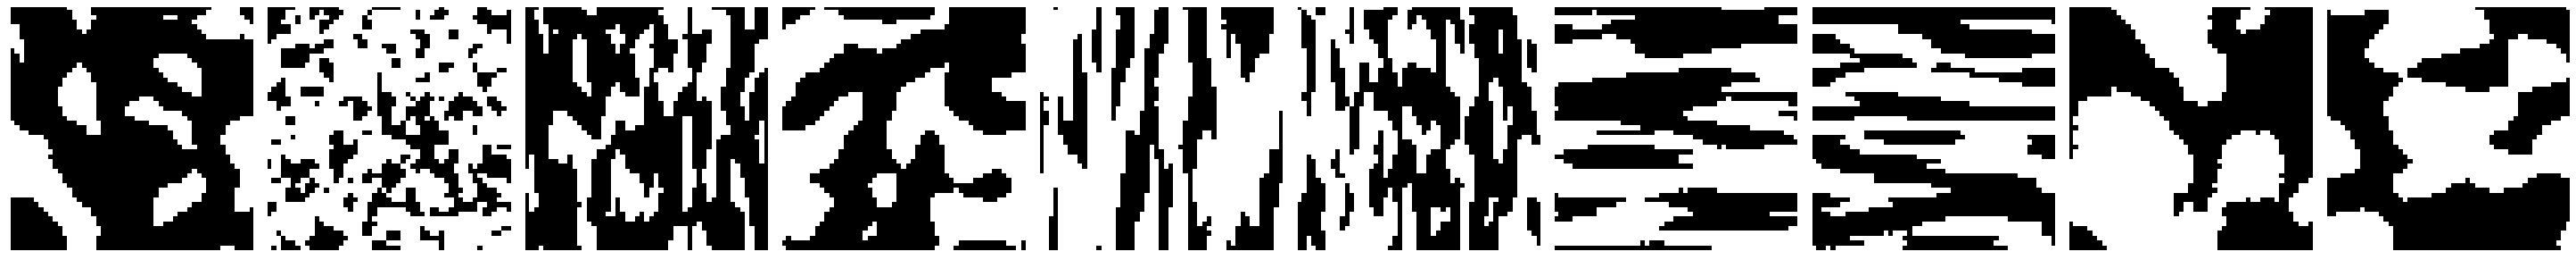

In [180]:
plot_microstructures(*x_data[:10].reshape(10, 51, 51, 51)[:, :, :, 0], cmap='gray', colorbar=False);

# Make PCA Data

In [174]:
x_data_da = da.from_array(x_data, chunks=(100, -1))

In [181]:
model = make_pca_model()
x_data_pca = model.fit_transform(x_data_da).compute()

In [182]:
del x_data
del x_data_da

In [183]:
print(x_data_pca.shape)
print(y_data.shape)

(8900, 15)
(8900,)


In [184]:
np.savez('data_pca.npz', x_data_pca=x_data_pca, y_data=y_data)

## Load the PCA Data

In [335]:
data = np.load('data_pca.npz')

In [336]:
x_data_pca = data['x_data_pca']
y_data = data['y_data']

# Train test split and PCA

In [337]:
def split(x_data, y_data, train_sizes=(0.9, 0.03), random_state=None):
    x_train, x_test, y_train, y_test = train_test_split(
        x_data,
        y_data,
        train_size=train_sizes[0],
        random_state=random_state
    )
    x_pool, x_calibrate, y_pool, y_calibrate = train_test_split(
        x_train,
        y_train,
        test_size=train_sizes[1],
        random_state=random_state
    ) 
    return x_pool, x_test, x_calibrate, y_pool, y_test, y_calibrate

## Test the model

In [437]:
x_pool, x_test, x_train, y_pool, y_test, y_train = split(
    x_data_pca[:, :3], y_data, train_sizes=(0.87, 0.003)
)

In [438]:
x_pool.shape

(7719, 3)

In [439]:
x_test.shape

(1157, 3)

In [440]:
x_train.shape

(24, 3)

In [441]:
#model = make_gp_model_matern()
model = make_linear_model()

In [442]:
model.fit(x_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('regressor', LinearRegression())])

In [366]:
%%timeit
y_pool_predict = model.predict(x_pool)

1.21 ms ± 22.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [367]:
%%timeit
y_pool_predict = model.predict(x_pool)

1.19 ms ± 30.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [443]:
#y_pool_predict, pool_std = model.predict(x_pool, return_std=True)
y_pool_predict = model.predict(x_pool)

In [444]:
y_test_predict = model.predict(x_test)

In [445]:
print(np.sort(pool_std))

[0.01133097 0.09665116 0.09746314 ... 0.99753447 0.99835071 0.99962859]


<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

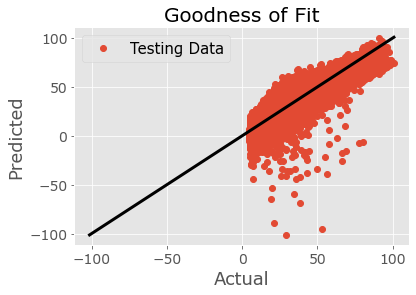

In [446]:
plot_parity(y_pool, y_pool_predict)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

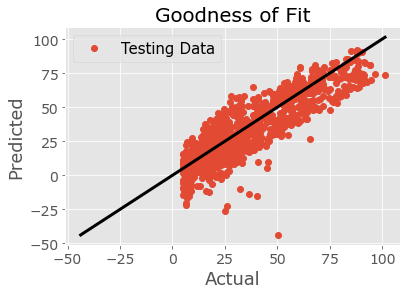

In [447]:
plot_parity(y_test, y_test_predict)

In [448]:
from sklearn.metrics import r2_score

print(r2_score(y_test, y_test_predict))
#print(y_test.shape)
#print(y_test)
print(model.score(x_test, y_test))

0.7320334924627605
0.7320334924627605


## Debug

In [215]:
def rework_pool(x_pool, y_pool, ids):
    x_, x_pool = split_on_ids(x_pool, ids)
    y_, y_pool = split_on_ids(y_pool, ids)
    return x_, x_pool, y_, y_pool

In [216]:
from active import next_sample_gsx, next_sample_igs

def query_helper(model, x_pool, y_pool, init_scores, update_scores, next_func):
    if not hasattr(model, 'query_data'):
        model.query_data = [], init_scores()
    labeled_samples, scores = model.query_data
    scores = update_scores(model, scores)
    next_id = next_func(labeled_samples, scores)
    model.query_data = (labeled_samples + [next_id], scores)
    x_, _, y_, _ = rework_pool(x_pool, y_pool, [next_id])
    return x_, x_pool, y_, y_pool


def gsx_query(model, x_pool, y_pool, batch_size):
    return query_helper(
        model,
        x_pool,
        y_pool,
        lambda: x_pool,
        lambda m, s: s,
        next_sample_gsx
    )

def gsy_query(model, x_pool, y_pool, batch_size):
    return query_helper(
        model,
        x_pool,
        y_pool,
        lambda: None,
        lambda m, s: m.predict(x_pool).reshape(-1, 1),
        next_sample_gsx
    )


def igs_query(model, x_pool, y_pool, batch_size):
    return query_helper(
        model,
        x_pool,
        y_pool,
        lambda: (x_pool, None),
        lambda m, s: (s[0], m.predict(x_pool).reshape(-1, 1)),
        next_sample_igs
    )


In [217]:
def query_uncertainty(model, x_pool, y_pool, batch_size):
    stds = model.predict(x_pool, return_std=True)[1]
    ids = np.argsort(stds)[::-1][:batch_size]
    return rework_pool(x_pool, y_pool, ids)

def query_random(model, x_pool, y_pool, batch_size):
    index = np.random.randint(0, len(x_pool))
    return rework_pool(x_pool, y_pool, [index])


def evaluate_model(x_pool, x_test, x_train, y_pool, y_test, y_train, model, query_func, batch_size):
    model.fit(x_train, y_train)
    train_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)
    x_, x_pool, y_, y_pool = query_func(model, x_pool, y_pool, batch_size)
    x_train = np.vstack([x_train, x_])
    y_train = np.append(y_train, y_)
    return model, x_pool, x_train, y_pool, y_train, test_score, train_score

In [399]:
def run(data, query_func, model_func, n_iter, train_sizes=(0.87, 0.004)):
    x_pool, x_test, x_train, y_pool, y_test, y_train = data
    model = model_func()
    train_scores = []
    test_scores = []
    for _ in range(n_iter):
#        model_ = model
#        model = model_func()
#        if hasattr(model_, "query_data"):
#            model.query_data = model_.query_data
        model, x_pool, x_train, y_pool, y_train, test_score, train_score  = evaluate_model(
            x_pool, x_test, x_train, y_pool, y_test, y_train,
            model, 
            query_func,
            1
        )
        train_scores += [train_score]
        test_scores += [test_score]
       
    return train_scores, test_scores
    

In [207]:
data = split(x_data_pca, y_data, train_sizes=(0.87, 0.004))
train_scores, test_scores_uncertainty = run(data, query_uncertainty, make_gp_model_matern, 300)
train_scores, test_scores_random = run(data, query_random, make_gp_model_matern, 300)
train_scores, test_scores_gsx = run(data, gsx_query, make_gp_model_matern, 300)
train_scores, test_scores_gsy = run(data, gsy_query, make_gp_model_matern, 300)
train_scores, test_scores_igs = run(data, igs_query, make_gp_model_matern, 300)

In [208]:
scores = dict(
    random=test_scores_random,
    uncertainty=test_scores_uncertainty,
    gsx=test_scores_gsx,
    gsy=test_scores_gsy,
    igs=test_scores_igs
)

In [462]:
import matplotlib

def plot_scores(scores, error_freq=20):

    plt.style.use('ggplot')
    plt.figure(figsize=(10, 8))
    plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=14) 
    ax = plt.gca()
    matplotlib.rc('font', **dict(size=16))
    names = dict(
        uncertainty='Uncertainty',
        random="Random",
        gsx="GSX",
        gsy="GSY",
        igs="IGS"
    )

    for k, v in scores.items():
        y = v['mean']
        x = np.arange(len(y))
        p = ax.plot(x, y, label=names[k], lw=3)
        e = v['std']
        if k in ['uncertainty', 'gsx', 'gsy', 'igs', 'random']:
            xe, ye, ee = x[10::error_freq], y[10::error_freq], e[10::error_freq]
            ax.errorbar(xe, ye, yerr=ee, alpha=0.5, fmt='o', markersize=0, ecolor=p[-1].get_color(), elinewidth=3, capsize=4, capthick=3)
 #       ax.fill_between(x, y - e, y + e, alpha=0.1)
        
    plt.legend(fontsize=16)
    plt.xlabel('N (queries)', fontsize=16)
    plt.ylabel(r'$R^2$', fontsize=16);
    plt.ylim(0.3, 1)
    
#plot_scores(scores)

## Multiple runs

In [472]:
learners_gp = dict(
    uncertainty=(query_uncertainty, make_gp_model_matern),
    random=(query_random, make_gp_model_matern),
    gsx=(gsx_query, make_gp_model_matern),
    gsy=(gsy_query, make_gp_model_matern),
    igs=(igs_query, make_gp_model_matern)
)

In [473]:
import tqdm

def run_all(x_data_pca, y_data, train_sizes, learners, n_query):
    data = split(x_data_pca, y_data, train_sizes)
    test_scores = dict()
    for k in tqdm.tqdm(learners):
        test_scores[k] = run(data, learners[k][0], learners[k][1], n_query)[1]
    return test_scores

In [227]:
scores = run_all(x_data_pca, y_data, (0.87, 0.004), learners)

100%|██████████| 5/5 [02:19<00:00, 27.98s/it]


In [474]:
from toolz.curried import map as fmap

def merge_func(x):
    return dict(
        mean=np.mean(x, axis=0),
        std=np.std(x, axis=0),
        scores=np.array(x)
    )

def run_multiple(x_data_pca, y_data, train_sizes, learners, n_query, n_iter):
    _ = fmap(lambda _: run_all(x_data_pca, y_data, train_sizes, learners, n_query), range(n_iter))
    all_data = list(_)
    return merge_with(merge_func, *all_data)

In [475]:
output = run_multiple(x_data_pca, y_data, (0.87, 0.004), learners_gp, 300, 10)

100%|██████████| 5/5 [02:38<00:00, 31.75s/it]


In [469]:
output

{'random': {'mean': array([-3.43887042e+00, -1.95180073e+00, -2.29848515e+00, -2.54184069e+00,
         -1.46354100e+00, -1.16187848e+00, -1.14623483e+00, -9.08358861e-01,
         -8.15425426e-01, -1.04427280e+00, -8.44566849e-01, -6.60050125e-01,
         -6.50297682e-01, -7.70645134e-01, -5.25418594e-01, -4.10500065e-01,
         -3.68242811e-01, -3.72817522e-01, -4.21299382e-01, -5.89878335e-01,
         -5.42975248e-01, -6.85825010e-01, -6.85126686e-01, -7.52866833e-01,
         -7.13011857e-01, -9.63646263e-01, -9.04703815e-01, -9.37909886e-01,
         -1.07255817e+00, -1.08891154e+00, -1.01882175e+00, -9.60712935e-01,
         -9.59519903e-01, -9.17485903e-01, -8.82904837e-01, -9.74783893e-01,
         -1.01203569e+00, -1.23968979e+00, -1.36438625e+00, -1.26345725e+00,
         -1.29064930e+00, -1.12788432e+00, -1.09812739e+00, -1.43616248e+00,
         -1.51789103e+00, -1.68008369e+00, -1.73247069e+00, -1.72276421e+00,
         -1.86833674e+00, -2.04056482e+00, -2.08294313e+00

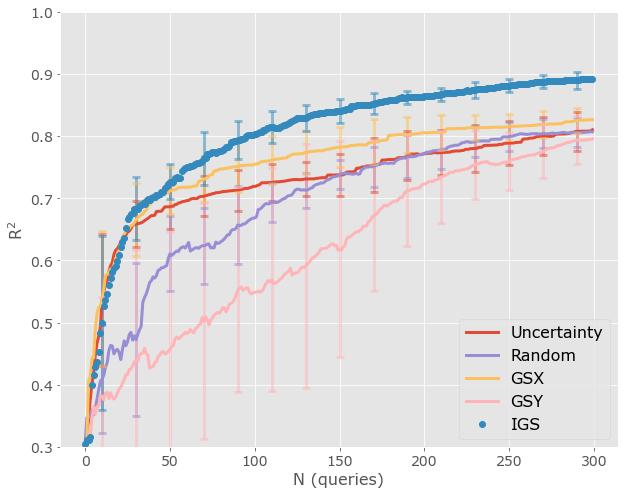

In [476]:
plot_scores(output)

In [292]:
output200 = output

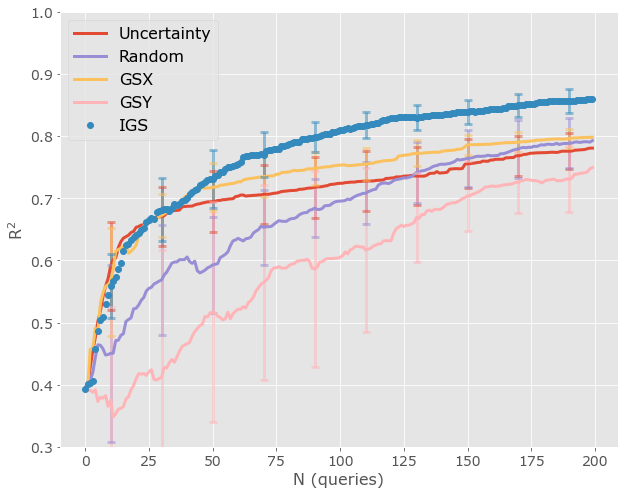

In [293]:
plot_scores(output200) # 200 iterations

## Linear Model

In [400]:
learners = dict(
    random=(query_random, make_linear_model),
    gsx=(gsx_query, make_linear_model),
    gsy=(gsy_query, make_linear_model),
    igs=(igs_query, make_linear_model)
)

In [461]:
output = run_multiple(x_data_pca[:, :3], y_data, (0.87, 0.002), learners, 50, 100)

100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


In [459]:
output

{'random': {'mean': array([-0.51390275, -0.15713026,  0.1076351 ,  0.2803239 ,  0.34858877,
          0.41645791,  0.39017921,  0.38833622,  0.48702932,  0.41874759,
          0.42719317,  0.4269802 ,  0.60307458,  0.60334796,  0.62318058,
          0.6297118 ,  0.61480394,  0.60558169,  0.64714173,  0.6904845 ,
          0.68513111,  0.70300185,  0.72012652,  0.7195898 ,  0.71741667,
          0.7231449 ,  0.7224909 ,  0.72751881,  0.73532443,  0.73546753,
          0.74055589,  0.73889846,  0.74055758,  0.74069032,  0.74087212,
          0.74445936,  0.74456792,  0.7470554 ,  0.74923757,  0.75052208,
          0.75465729,  0.76090556,  0.76215578,  0.76132842,  0.76229347,
          0.76123587,  0.76354118,  0.76451862,  0.76645301,  0.7695734 ]),
  'std': array([1.68498251, 1.17736607, 0.9139373 , 0.76802416, 0.74846948,
         0.69319307, 0.70626364, 0.6927288 , 0.53199026, 0.74995527,
         0.72360003, 0.72616164, 0.25222354, 0.26751031, 0.24412908,
         0.2287086 , 0.272

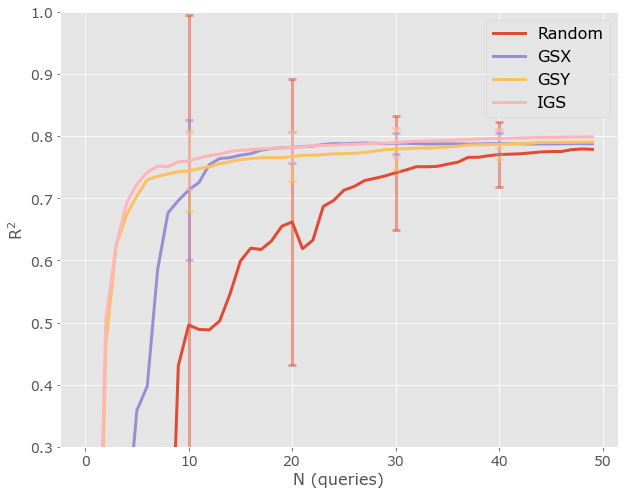

In [463]:
plot_scores(output, error_freq=10)

## Run the learners (linear model)

In [65]:
scores = multiple_rounds(x_data_pca, y_data, 1, 200, make_learners, oracle_func, (0.85, 0.14, 0.01), 99)

ValueError: The sum of train_size and test_size = 8901, should be smaller than the number of samples 8900. Reduce test_size and/or train_size.

In [13]:
scores

{'uncertainty': (array([0.25093736, 0.25231435, 0.25265297, 0.27597016, 0.28235489,
         0.29417141, 0.29895908, 0.3586229 , 0.35905795, 0.37961186,
         0.38165304, 0.46088473, 0.47217475, 0.49162383, 0.49712805,
         0.49993611, 0.50780705, 0.54082693, 0.54456647, 0.55739068,
         0.56403651, 0.56488498, 0.56504344, 0.55897878, 0.56045872,
         0.56243565, 0.56615086, 0.60910175, 0.63321333, 0.64160199,
         0.64309872, 0.64360946, 0.65394703, 0.65393267, 0.65375954,
         0.66115616, 0.66123555, 0.66157238, 0.66132524, 0.66856848,
         0.66863574, 0.68958438, 0.68979588, 0.68918647, 0.68908729,
         0.68912335, 0.69331862, 0.69383677, 0.69786786, 0.69889581,
         0.69885267, 0.69931208, 0.69946337, 0.69945925, 0.6996109 ,
         0.69976408, 0.69976583, 0.70151824, 0.70247879, 0.70250469,
         0.70254605, 0.70178319, 0.7154425 , 0.71946604, 0.71944055,
         0.71961872, 0.71961829, 0.71963285, 0.72136491, 0.72144723,
         0.72274516

In [31]:
scores

{'uncertainty': (array([ 0.68904719,  0.68974073,  0.69008438,  0.6903726 ,  0.68930675,
          0.68994369,  0.69033386,  0.69071379,  0.68931731,  0.68853305,
         -2.28791773]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))}

(0.0, 1.0)

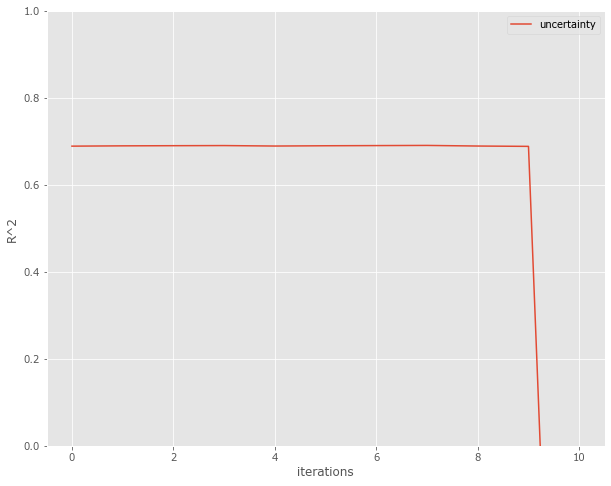

In [33]:
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

plt.style.use('ggplot')
plt.figure(figsize=(10, 8))
ax = plt.gca()

for k, v in scores.items():
    y = v[0]
    e = v[1]
    x = np.arange(len(y))
    ax.plot(x, y, label=k, linestyle=next(linecycler))
    if k in ['std', 'bayes', 'gsx', 'gsy', 'igs']:
        ax.fill_between(x, y - e, y + e, alpha=0.1)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('R^2');
plt.ylim(0, 1)

## Run the learners (GP model)

In [12]:
scores = multiple_rounds(x_data[:n_use], y_data[:n_use], 1, 20, make_learners, oracle_func, props, 99)

NameError: name 'x_data' is not defined

In [15]:
scores


{'uncertainty': (array([ 0.56338491,  0.56261501,  0.56241542,  0.6089452 ,  0.62341315,
          0.62559374, -2.30585858, -2.30587505, -2.30587362, -2.30587505,
          0.75620825, -2.30587505,  0.42593145,  0.33812503,  0.31843733,
          0.62564616,  0.30494424,  0.24395588, -2.30410289,  0.35292066,
         -0.34776795]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.])),
 'random': (array([0.56338491, 0.57827383, 0.58187398, 0.59401296, 0.59397805,
         0.61836939, 0.62941761, 0.63709403, 0.64032037, 0.74286012,
         0.75542221, 0.75728636, 0.73888593, 0.7123319 , 0.74985073,
         0.76956591, 0.63018141, 0.76431861, 0.78778076, 0.77083507,
         0.7544838 ]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.])),
 'bayes': (array([ 0.56338491, -0.00659136,  0.62108636,  0.75476722,  0.68497973,
          0.68324156, -2.30587505, -2.30587505,  0.71791255, -2


## The results

(0.0, 1.0)

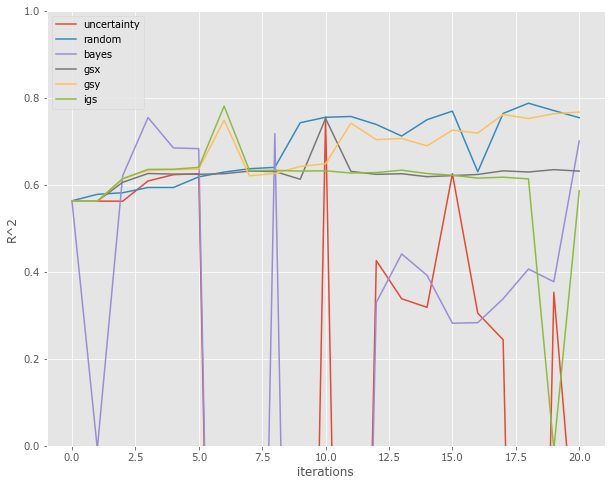

In [16]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 8))
ax = plt.gca()

for k, v in scores.items():
    y = v[0]
    e = v[1]
    x = np.arange(len(y))
    ax.plot(x, y, label=k)
    if k in ['std', 'bayes', 'gsx', 'gsy', 'igs']:
        ax.fill_between(x, y - e, y + e, alpha=0.1)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('R^2');
plt.ylim(0, 1)

(0.9, 1.0)

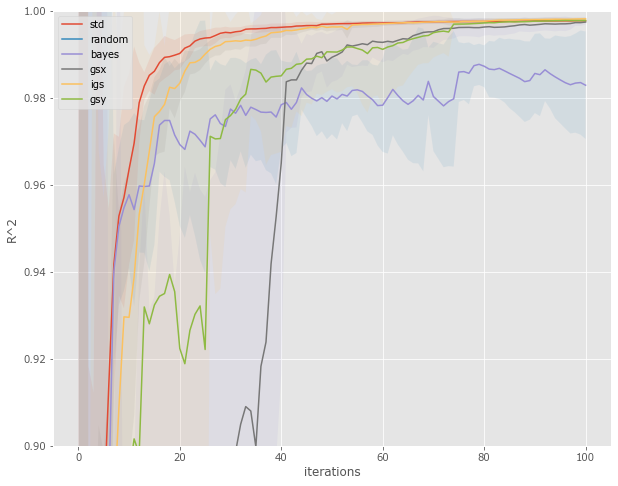

In [99]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 8))
ax = plt.gca()

for k, v in scores.items():
    y = v[0]
    e = v[1]
    x = np.arange(len(y))
    ax.plot(x, y, label=k)
    if k in ['std', 'bayes', 'gsx', 'gsy', 'igs']:
        ax.fill_between(x, y - e, y + e, alpha=0.1)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('R^2');
plt.ylim(0.9, 1)

## Check what the accuracy actually looks like

In [79]:
y_pred_std = learner_accuracy['std'][1].predict(x_test)
y_pred_random = learner_accuracy['random'][1].predict(x_test)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

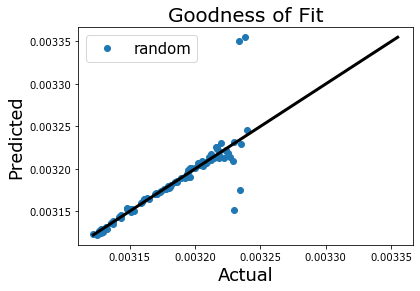

In [89]:
plot_parity(y_test, y_pred_random, label='random')

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

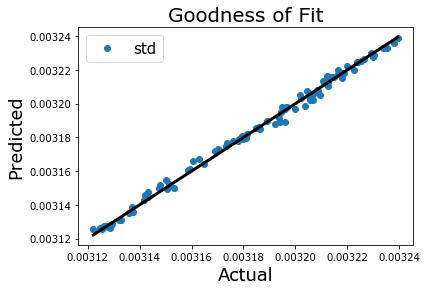

In [90]:
plot_parity(y_test, y_pred_std, label='std')